# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [110]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [111]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.common import get_name_15min_chart, get_name_15min_chart_now

## yfinance による株価データの取得

In [112]:
code = "N225"
symbol = f"^{code}"
ticker = yf.Ticker(symbol)
df = ticker.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-09-18 09:00:00+09:00,44910.500000,45011.488281,44826.160156,45005.628906,0,0.0,0.0
2025-09-18 09:15:00+09:00,45008.179688,45055.988281,44815.398438,44880.468750,0,0.0,0.0
2025-09-18 09:30:00+09:00,44880.738281,45014.621094,44874.500000,45009.011719,0,0.0,0.0
2025-09-18 09:45:00+09:00,45008.121094,45010.500000,44883.281250,44961.171875,0,0.0,0.0
2025-09-18 10:00:00+09:00,44957.859375,45090.019531,44942.910156,45082.878906,0,0.0,0.0
2025-09-18 10:15:00+09:00,45084.390625,45144.621094,45072.500000,45100.949219,0,0.0,0.0
2025-09-18 10:30:00+09:00,45095.011719,45163.859375,45094.531250,45155.390625,0,0.0,0.0
2025-09-18 10:45:00+09:00,45160.320312,45205.191406,45151.089844,45186.089844,0,0.0,0.0
2025-09-18 11:00:00+09:00,45186.160156,45286.351562,45176.949219,45286.351562,0,0.0,0.0


## 前日終値の取得

In [113]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-09-11 00:00:00+09:00    44372.500000
2025-09-12 00:00:00+09:00    44768.121094
2025-09-16 00:00:00+09:00    44902.269531
2025-09-17 00:00:00+09:00    44790.378906
2025-09-18 00:00:00+09:00    45368.050781
Name: Close, dtype: float64


Date
2025-09-17 00:00:00+09:00    44790.378906
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [114]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+120.12


## ローソク足チャート（小さいサイズ）

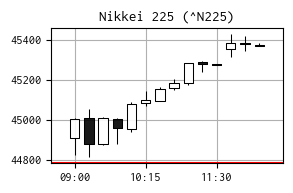

In [115]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 9

fig, ax = plt.subplots(figsize=(3, 2))
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.set_ylabel(None)
ax.grid()

if "shortName" in ticker.info:
    ax.set_title(f"{ticker.info['shortName']} ({symbol})")
elif "longName" in ticker.info:
    ax.set_title(f"{ticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()